In [3]:
#####################
# IMPORT LIBS
#####################

from PIL import Image
from sklearn.model_selection import train_test_split
from skimage import io, transform
from skimage.transform import AffineTransform, warp
from sklearn.metrics import roc_auc_score, mean_absolute_error
import tensorflow as tf

from tensorflow.keras.models import load_model
from tensorflow.compat.v1.keras import backend as K

import pandas as pd
from pathlib import Path
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
import glob
import albumentations as A
import cv2
# from efficientnet_pytorch import EfficientNet


#####################
# SET CONSTANTS
#####################

INPUT_PATH = Path('../input')
OUTPUT_PATH = Path('../output')
TRAIN_PATH = INPUT_PATH / 'idao_dataset' / 'train'
PRIVATE_PATH = INPUT_PATH / 'idao_dataset' / 'private_test'
PRIVATE_PATH_NEW = INPUT_PATH / 'idao_dataset' / 'private_test_new'
PUBLIC_PATH = INPUT_PATH / 'idao_dataset' / 'public_test'

RANDOM_SEED = 4444

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(RANDOM_SEED)

In [4]:
class Config:
    BATCH_SIZE = 32
    TRAINING_EPOCHS = 150
    VALIDATION_STEPS_PER_EPOCH = 30
    VALIDATION_EPOCHS = 10
    STEPS_PER_EPOCH = 30
    EARLY_STOP_PATIENCE = 20
    
    
    # Declare an augmentation pipeline
    train_transform = A.Compose([
        #A.HorizontalFlip(p=0.5),
        #A.HorizontalFlip(p=0.5),
        #A.VerticalFlip(p=0.5),
        A.Cutout(num_holes=4, max_h_size=8, max_w_size=8, p=0.3),
        A.OneOf([A.RandomContrast(),
             A.RandomGamma(),
             A.RandomBrightness()],p=0.2),
        A.OneOf([A.Blur(p = 0.3),
             A.GaussNoise(p=0.3)
                ],p=0.5),
        A.CLAHE(clip_limit=4, tile_grid_size=(8,8), always_apply=False, p=0.3),
    ],)
    
    validation_transform = A.Compose([
    ],)

In [5]:
def getFeatures(img_path):
    if len(img_path.split('_')) == 18:
        particle_class = 1 # ER
        particle_energy = int(img_path.split('_')[7])
    else:
        particle_class = 0 # HE
        particle_energy = int(img_path.split('_')[8])
    particle_angle = float(img_path.split('/')[-1].split('__')[0])
    return [img_path, particle_class, particle_energy, particle_angle]

images = glob.glob(str(TRAIN_PATH / '**/*.png'), recursive=True)
images = pd.DataFrame(map(getFeatures, images))
images.columns = ['path', 'class', 'energy', 'angle']

In [6]:
#################
# EXTRACT TEST
#################

# HE - 0, ER - 1

he_test_idx = list(images[(images['class'] == 1) & (images['energy'].apply(lambda x: x in [1, 6, 20]))].index)
er_test_idx = list(images[(images['class'] == 0) & (images['energy'].apply(lambda x: x in [3, 10, 30]))].index)

In [7]:
# TODO: Write this to a separate folder

# 0 - [:750]
# 1 - [750:1502]
# 0 - [1502:7531]
# 1 - [7531:]

import glob
private_test = glob.glob(str(PRIVATE_PATH / '**/*.png'), recursive=True)
public_test = glob.glob(str(PUBLIC_PATH / '**/*.png'), recursive=True)

sample_submission = pd.read_csv(INPUT_PATH / 'track1_predictions_example.csv')
private_ids = [t.split('/')[-1].split('.')[0] for t in private_test]
public_ids = [t.split('/')[-1].split('.')[0] for t in public_test]

# sample_submission['path'] = sample_submission['id'].apply(lambda x: PRIVATE_PATH / f'{x}.png' if x in private_ids else PUBLIC_PATH / f'{x}.png').map(str)
# sample_submission.iloc[:750, 1] = 1
# sample_submission.iloc[750:1502, 1] = 0
# sample_submission.iloc[1502:7531, 1] = 1
# sample_submission.iloc[7531:, 1] = 0

# sample_submission = sample_submission.iloc[1502:].reset_index(drop = True)

# images_leak = pd.DataFrame(np.array([sample_submission.iloc[:, 3].values, sample_submission.iloc[:, 1].values, sample_submission.iloc[:, 2].values]).T)
# images_leak.columns = ['path', 'class', 'energy']

In [8]:
test_idx = he_test_idx + er_test_idx
test_images = images.iloc[test_idx]
images = images.drop(index = test_idx)


train_images, valid_images = train_test_split(images, shuffle = True, random_state = RANDOM_SEED)
train_images = train_images.reset_index(drop = True)
valid_images = valid_images.reset_index(drop = True)

In [9]:
def calc_metric(y_binary_true, y_binary_pred, y_reg_true, y_reg_pred):
    '''
    Competition metric
    '''
    
    roc = roc_auc_score(y_binary_true, y_binary_pred)
    mae = mean_absolute_error(y_reg_true, y_reg_pred)
    return 1000 * (roc - mae), roc, mae

In [59]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images, transform=None, batch_size=32,  shuffle=True, is_classification = True, augment = False):
        self.images = images
        self.indices = np.arange(len(images))
        self.transform = transform
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.is_classification = is_classification
        
        self.on_epoch_end()

    def __len__(self):
        int_batch_size = len(self.images) // self.batch_size
        
        if len(self.images) % self.batch_size != 0:
            return int_batch_size + 1
        return int_batch_size

    def __getitem__(self, index):
        index = self.index[index * self.batch_size:(index + 1) * self.batch_size]
        batch = [self.indices[k] for k in index]
    
        X, y = self.__get_data(batch)
        return X, y

    def on_epoch_end(self):
        self.index = np.arange(len(self.indices))
        if self.shuffle:
            np.random.shuffle(self.index)
            
    def get_label(self, y_energy):
        if (y_energy>=1)&(y_energy <= 3):
            y_energy = [1,0,0]
        elif (y_energy>=6)&(y_energy <= 10):
            y_energy = [0,1,0]
        elif (y_energy>=20)&(y_energy <= 30):
            y_energy = [0,0,1]
        
        return y_energy

    def __get_data(self, batch):
        X = np.zeros((len(batch), 128, 128, 3))
        y_class = np.zeros((len(batch),))
        y_energy = np.zeros((len(batch),))
        y_angle = np.zeros((len(batch),))
        for i, idx in enumerate(batch):
            image=cv2.imread(self.images.iloc[idx, 0])
            center = image.shape[0] // 2
            image = image[center-128//2:center+128//2,center-128//2:center+128//2, :]
            X[i,] = image
            
            if self.augment:
                X[i, ] = Config.train_transform(image=X[i,].astype(np.uint8))['image']
            particle_class = self.images.iloc[idx, 1]
            particle_energy = self.images.iloc[idx, 2]
            particle_angle = self.images.iloc[idx, 3]
            
            y_class[i] = particle_class
            y_energy[i] = particle_energy # self.get_label(particle_energy)
            y_angle[i] = particle_angle
        if self.is_classification:
            return X / 255.0, y_class
        
        return X / 255.0, y_energy


In [51]:
train_datagen = DataGenerator(train_images, batch_size = Config.BATCH_SIZE, is_classification = False, augment = False)
valid_datagen = DataGenerator(valid_images, batch_size = Config.BATCH_SIZE, is_classification = False)
test_datagen = DataGenerator(test_images, batch_size = 1, is_classification = False, shuffle = False)

In [29]:
# Example data extract

X, y_energy = train_datagen.__getitem__(0)

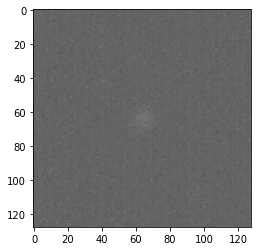

In [30]:
idx = 17
plt.imshow((X[idx] * 255).astype(np.uint8))

## Class model

In [14]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications import ResNet152V2

from tensorflow.keras.applications import EfficientNetB0
import numpy as np

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128,128,3))

In [15]:
from tensorflow.keras import layers as L
from tensorflow.keras.models import Model
import tensorflow as tf
import tensorflow.keras
import tensorflow
from tensorflow.keras import regularizers

earlystop = tensorflow.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=Config.EARLY_STOP_PATIENCE)
ckpt = tensorflow.keras.callbacks.ModelCheckpoint(OUTPUT_PATH / 'models' / 'regression_own', save_best_only=True, monitor='val_mean_absolute_error', mode='min')
    
def create_regression_model():
    
    # Model receives black and white 64 x 64 images as input
    inp = L.Input(shape=(128,128,3))

    # Sequence of two convolutional and pooling layers as feature extractors
    x = L.Conv2D(8, kernel_size=2, activation='relu')(inp)
    x = L.BatchNormalization()(x)
    x = L.Conv2D(8, kernel_size=2, activation='relu')(inp)
    x = L.BatchNormalization()(x)
    x = L.MaxPooling2D(pool_size=(2, 2))(x)
    x = L.Dropout(0.1)(x)
    
    x = L.Conv2D(16, kernel_size=2, activation='relu')(x)
    x = L.BatchNormalization()(x)
    x = L.Conv2D(16, kernel_size=2, activation='relu')(x)
    x = L.BatchNormalization()(x)
    x = L.MaxPooling2D(pool_size=(2, 2))(x)
    x = L.Dropout(0.1)(x)
    
    x = L.Conv2D(32, kernel_size=2, activation='relu')(x)
    x = L.BatchNormalization()(x)
    x = L.Conv2D(32, kernel_size=2, activation='relu')(x)
    x = L.BatchNormalization()(x)
    x = L.MaxPooling2D(pool_size=(2, 2))(x)
    x = L.Dropout(0.1)(x)
    
    x = L.Conv2D(64, kernel_size=2, activation='relu')(x)
    x = L.BatchNormalization()(x)
    x = L.Conv2D(64, kernel_size=2, activation='relu')(x)
    x = L.BatchNormalization()(x)
    x = L.MaxPooling2D(pool_size=(2, 2))(x)
    x = L.Dropout(0.1)(x)
    
#     x = L.Conv2D(256, kernel_size=2, activation='relu')(x)
#     x = L.BatchNormalization()(x)
#     x = L.Conv2D(256, kernel_size=2, activation='relu')(x)
#     x = L.BatchNormalization()(x)
#     x = L.MaxPooling2D(pool_size=(2,2))(x)
        
#     x = base_model.output
    x = L.GlobalAveragePooling2D()(x)
    # let's add a fully-connected layer
    x = L.Dense(64, activation='relu')(x)
    x = L.Dense(16, activation='relu')(x)
    # and a logistic layer -- let's say we have 200 classes
    #predictions_energy = L.Dense(3, activation= 'softmax', name='energy')(x)
    
    predictions_energy = L.Dense(1, name='energy')(x)
    #predictions_class = L.Dense(1, activation='sigmoid', name='class')(x)
    #predictions_angle = L.Dense(1, name='angle')(x)

    # this is the model we will train
    model = Model(inputs=inp, outputs=[predictions_energy])


    # compile the model (should be done *after* setting layers to non-trainable)
    model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=1e-4), 
                  loss={#'class': 'binary_crossentropy', 
                        'energy':'mean_absolute_error', 
                        #'angle': 'mean_absolute_error'
                  },
                  metrics = {#'class': 'AUC', 
                             'energy': 'mean_absolute_error', 
                             #'angle': 'mean_absolute_error'
                  })
    return model

In [16]:
# def create_regression_model(base_model, l2_loss_lambda = 1e-4):
    
#     for layer in base_model.layers:
#         layer.trainable = False
        
        
#     x = base_model.output
#     x = L.GlobalAveragePooling2D()(x)
#     # let's add a fully-connected layer
#     x = L.Dense(256, activation='relu')(x)
#     x = L.Dense(64, activation='relu')(x)
#     # and a logistic layer -- let's say we have 200 classes
#     #predictions_energy = L.Dense(3, activation= 'softmax', name='energy')(x)
    
#     predictions_energy = L.Dense(1, name='energy')(x)

#     # this is the model we will train
#     model = Model(inputs=base_model.input, outputs=[predictions_energy])

#     # compile the model (should be done *after* setting layers to non-trainable)
#     model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=1e-4), 
#                   loss={#'class': 'binary_crossentropy', 
#                         'energy':'mean_absolute_error', 
#                         #'angle': 'mean_absolute_error'
#                   },
#                   metrics = {#'class': 'AUC', 
#                              'energy': 'mean_absolute_error', 
#                              #'angle': 'mean_absolute_error'
#                   })
#     return model

In [17]:
model = create_regression_model()

In [18]:
model.fit(
    train_datagen, 
    steps_per_epoch = Config.STEPS_PER_EPOCH, 
    validation_data = valid_datagen, 
    validation_steps = Config.VALIDATION_STEPS_PER_EPOCH, 
    epochs = Config.TRAINING_EPOCHS,
    verbose = 1,
    callbacks = [earlystop, ckpt]
    )

Epoch 1/150
30/30 [==============================] - 9s 219ms/step - loss: 10.1884 - mean_absolute_error: 10.1884 - val_loss: 11.7385 - val_mean_absolute_error: 11.7385
INFO:tensorflow:Assets written to: ../output/models/regression_own/assets
Epoch 2/150
30/30 [==============================] - 6s 214ms/step - loss: 9.4349 - mean_absolute_error: 9.4349 - val_loss: 12.1111 - val_mean_absolute_error: 12.1111
Epoch 3/150
30/30 [==============================] - 6s 211ms/step - loss: 9.4474 - mean_absolute_error: 9.4474 - val_loss: 11.6352 - val_mean_absolute_error: 11.6352
INFO:tensorflow:Assets written to: ../output/models/regression_own/assets
Epoch 4/150
30/30 [==============================] - 6s 214ms/step - loss: 8.3997 - mean_absolute_error: 8.3997 - val_loss: 11.9522 - val_mean_absolute_error: 11.9522
Epoch 5/150
30/30 [==============================] - 6s 210ms/step - loss: 7.8357 - mean_absolute_error: 7.8357 - val_loss: 11.6047 - val_mean_absolute_error: 11.6047
INFO:tensorflow

30/30 [==============================] - 6s 214ms/step - loss: 1.9157 - mean_absolute_error: 1.9157 - val_loss: 1.3232 - val_mean_absolute_error: 1.3232
INFO:tensorflow:Assets written to: ../output/models/regression_own/assets
Epoch 42/150
30/30 [==============================] - 6s 215ms/step - loss: 2.2805 - mean_absolute_error: 2.2805 - val_loss: 1.3991 - val_mean_absolute_error: 1.3991
Epoch 43/150
30/30 [==============================] - 6s 212ms/step - loss: 1.6922 - mean_absolute_error: 1.6922 - val_loss: 1.5142 - val_mean_absolute_error: 1.5142
Epoch 44/150
30/30 [==============================] - 6s 213ms/step - loss: 1.8834 - mean_absolute_error: 1.8834 - val_loss: 1.3813 - val_mean_absolute_error: 1.3813
Epoch 45/150
30/30 [==============================] - 6s 211ms/step - loss: 1.6344 - mean_absolute_error: 1.6344 - val_loss: 1.4362 - val_mean_absolute_error: 1.4362
Epoch 46/150
30/30 [==============================] - 6s 207ms/step - loss: 1.8716 - mean_absolute_error: 1.8

KeyboardInterrupt: 

In [19]:
model = tensorflow.keras.models.load_model(OUTPUT_PATH / 'models' / 'regression_own')

In [20]:
model.evaluate(valid_datagen, batch_size=64, steps=valid_images.shape[0] // 64)

51/51 [==============================] - 5s 103ms/step - loss: 1.3578 - mean_absolute_error: 1.3578


[1.3578271865844727, 1.3578271865844727]

In [31]:
model.evaluate(test_datagen, batch_size=8, steps=test_images.shape[0])

12/12 [==============================] - 0s 4ms/step - loss: 2.4645 - mean_absolute_error: 2.4645


[2.4645349979400635, 2.4645349979400635]

In [58]:
y_pred[-12:]

array([[  3.0532002],
       [155.99887  ],
       [155.99887  ],
       [155.99887  ],
       [155.99887  ],
       [155.99887  ],
       [155.99887  ],
       [155.99887  ],
       [155.99887  ],
       [155.99887  ],
       [155.99887  ],
       [155.99887  ]], dtype=float32)

In [36]:
#valid_datagen = DataGenerator(valid_images, batch_size = 1, is_classification = False, shuffle = False)
y_pred = model.predict(test_datagen, batch_size = 8)

In [37]:
y_pred.shape

(12, 1)

In [25]:
y_pred_changed = y_pred.copy()
y_pred_changed[test_images['class'] == 1, 0] = np.array([1,6,20])[np.argmin(np.abs(y_pred_changed[test_images['class'] == 1] - [1,6,20]), axis = 1)]
y_pred_changed[test_images['class'] == 0, 0] = np.array([3,10,30])[np.argmin(np.abs(y_pred_changed[test_images['class'] == 0] - [3,10,30]), axis = 1)]
y_pred_changed = y_pred_changed.reshape(-1)

In [26]:
mean_absolute_error(test_images['energy'], y_pred_changed)

0.0

In [51]:
model.save(OUTPUT_PATH / 'models' / 'cnn_classification')